# <br><br> **<font color='black'>Assignment-1-Group-27**
Members: Shubham Vashisth, Mohaddeseh Yaghoubpour, Emile Riberdy</font>

In [1]:
import os
import sklearn
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
SEED=42
np.random.seed(SEED)

### <font color='red'><b>Task 1: Data preprocessing</b></font>

#### <b>1.1 IMDB reviews</b>

In [2]:
def format_dataset(path):
    class_info = {}

    label = path.split('/')[-1]
    for reviews in os.listdir(path):
         with open(path+'/'+reviews, 'r', encoding='utf-8') as file:
             class_info[reviews.rstrip('.txt')] = file.read()

    imdb_df = pd.DataFrame.from_dict(data=class_info, orient='index')
    imdb_df['label'] = label
    imdb_df['id'] = imdb_df.index
    imdb_df = imdb_df.reset_index(drop=True)
    imdb_df = imdb_df.rename(columns={0: 'reviews'})
    imdb_df['rating'] = imdb_df['id'].apply(lambda x: float(x.split('_')[-1]))
    imdb_df['id'] = imdb_df['id'].apply(lambda x: int(x.split('_')[0]))
    imdb_df = imdb_df[['id', 'reviews', 'rating', 'label']]

    if label == 'neg':
        imdb_df['label'] = '-'
    else:
        imdb_df['label'] = '+'
    return imdb_df.sort_values(by='id').reset_index(drop='true')  

imdb_neg_df = format_dataset(path='datasets/aclImdb/train/neg')
imdb_pos_df = format_dataset(path='datasets/aclImdb/train/pos')
imdb_df = pd.concat([imdb_pos_df, imdb_neg_df], axis=0)
imdb_df = imdb_df.reset_index(drop=True)
imdb_df

,id,reviews,rating,label
0,0,Bromwell High is a cartoon comedy. It ran at t...,9.0,+
1,1,"If you like adult comedy cartoons, like South ...",7.0,+
2,2,Bromwell High is nothing short of brilliant. E...,9.0,+
3,3,"""All the world's a stage and its people actors...",10.0,+
4,4,FUTZ is the only show preserved from the exper...,8.0,+
...,...,...,...,...
24995,12495,"OK, I love bad horror. I especially love horro...",1.0,-
24996,12496,To be brutally honest... I LOVED watching Seve...,1.0,-
24997,12497,I'm sure that the folks on the Texas/Louisiana...,4.0,-
24998,12498,This film has the kernel of a really good stor...,2.0,-


##### <b>filtering words that appear in < 1% or > 50% of the documents</b>

In [3]:
from sklearn.datasets import load_svmlight_file

with open('datasets/aclImdb/imdb.vocab'  , 'r', encoding='utf-8') as vocab_file:
        vocabulary = vocab_file.read().splitlines()

features, ratings = load_svmlight_file('datasets/aclImdb/train/labeledBow.feat')
bow_features_df = pd.DataFrame(features.toarray(), columns=vocabulary)

word_freq = (bow_features_df > 0).sum() / len(bow_features_df)
word_freq = word_freq[(word_freq >= 0.01) & (word_freq <= 0.5)]

bow_features_df = bow_features_df[list(word_freq.index)]
bow_features_df['rating'] = ratings
cols = list(bow_features_df.columns)
cols.remove('rating')
cols.append('rating')
bow_features_df = bow_features_df[cols]

imdb_df = pd.merge(imdb_df, bow_features_df, left_index=True, right_index=True).drop('rating_x', axis=1)
imdb_df = imdb_df.rename(columns={'id_x': 'id', 'reviews_x': 'reviews', 'label_x': 'label', 'rating_y': 'rating'})
imdb_df

,id,reviews,label,he,his,!,by,an,who,they,...,portray,length,discovered,aware,continues,below,opens,essentially,received,rating
0,0,Bromwell High is a cartoon comedy. It ran at t...,+,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
1,1,"If you like adult comedy cartoons, like South ...",+,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
2,2,Bromwell High is nothing short of brilliant. E...,+,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
3,3,"""All the world's a stage and its people actors...",+,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,4,FUTZ is the only show preserved from the exper...,+,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,12495,"OK, I love bad horror. I especially love horro...",-,5.0,0.0,9.0,3.0,1.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
24996,12496,To be brutally honest... I LOVED watching Seve...,-,2.0,2.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24997,12497,I'm sure that the folks on the Texas/Louisiana...,-,0.0,2.0,0.0,2.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
24998,12498,This film has the kernel of a really good stor...,-,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


##### <b>Simple Linear Regression for selecting top features by their absolute regression coefficients w.r.t ratings</b>

In [4]:
class SimpleLinearRegression:
    def __init__(self, bias=True):
        self.bias = bias
        self.w = None
    
    def fit(self, X, y):
        if self.bias:
            X = np.column_stack([X, np.ones(X.shape[0])])
        self.w = np.linalg.lstsq(X, y, rcond=None)[0]  
        return self
    
    def predict(self, X):
        if self.bias:
            X = np.column_stack([X, np.ones(X.shape[0])])
        yhat = X @ self.w[:-1] + self.w[-1] 
        return yhat

X = imdb_df[imdb_df.columns[4:-1]]
y = imdb_df['rating']

reg = SimpleLinearRegression().fit(X, y)
coefficients = pd.DataFrame({'feature': list(imdb_df.columns[4:-1]), 'absolute regression coefficient': list(np.abs(reg.w))[:-1]})
coefficients['regression coefficient'] = list(reg.w[:-1])
coefficients =  coefficients.sort_values(by='regression coefficient', ascending=False).reset_index(drop=True)
coefficients

,feature,absolute regression coefficient,regression coefficient
0,funniest,0.815973,0.815973
1,wonderfully,0.707669,0.707669
2,superb,0.660227,0.660227
3,recommended,0.610879,0.610879
4,gem,0.609332,0.609332
...,...,...,...
1737,rubbish,0.726432,-0.726432
1738,disappointment,0.838321,-0.838321
1739,avoid,0.867500,-0.867500
1740,worst,0.913120,-0.913120


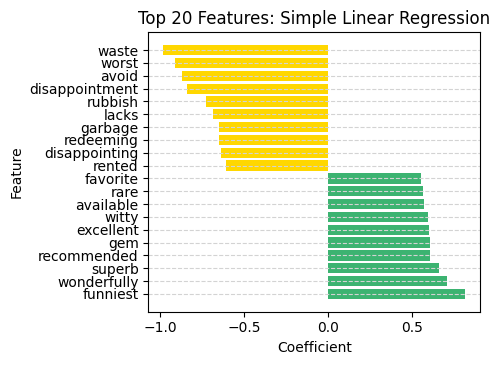

In [5]:
positive = coefficients.head(10)
negative = coefficients.tail(10)

top_features = pd.concat([positive, negative])

plt.figure(figsize=(5, 3.75))

plt.barh(top_features['feature'], top_features['regression coefficient'], color=['gold' if c < 0 else 'mediumseagreen' for c in top_features['regression coefficient']])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Top 20 Features: Simple Linear Regression')
plt.grid(axis='y', linestyle='--', color='lightgray')
plt.tight_layout()
plt.show()

In [6]:
# picking top 1000 features for IMDB reviews
imdb_top_features = coefficients.sort_values(by='absolute regression coefficient', ascending=False).head(1000)
imdb_top_features

,feature,absolute regression coefficient,regression coefficient
1741,waste,0.979451,-0.979451
1740,worst,0.913120,-0.913120
1739,avoid,0.867500,-0.867500
1738,disappointment,0.838321,-0.838321
0,funniest,0.815973,0.815973
...,...,...,...
513,lot,0.070760,0.070760
1259,unnecessary,0.070750,-0.070750
1258,high,0.070605,-0.070605
514,reading,0.070509,0.070509


#### <b>1.2 20 news group</b>

In [7]:
newsgrp_ds = sklearn.datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), 
            categories=('comp.graphics', 'sci.med', 'soc.religion.christian', 'talk.politics.mideast', 'rec.sport.hockey'))

newsgrp_df = pd.DataFrame({'text': newsgrp_ds.data, 'label': newsgrp_ds.target, 'label_name': [newsgrp_ds.target_names[i] for i in newsgrp_ds.target]})
newsgrp_df['text'] = newsgrp_df['text'].apply(lambda x: x.replace('\n', ' ').replace('\t', ' ').replace('\r', ' '))
newsgrp_df

,text,label,label_name
0,United States TV Schedule: April 18 Devils/I...,1,rec.sport.hockey
1,More like Philadelphia making dust out of d...,1,rec.sport.hockey
2,We also cannot fail to note the intense suffe...,3,soc.religion.christian
3,boards injuring his shoulder and they blotted ...,1,rec.sport.hockey
4,"You think that's bad ... one year, we had all...",1,rec.sport.hockey
...,...,...,...
2936,Here is a summary of Don Cherry's coach's corn...,1,rec.sport.hockey
2937,Does anybody have a collection of occurance...,0,comp.graphics
2938,Are 'Moody Monthly' and 'Moody' the same magaz...,3,soc.religion.christian
2939,How about Kirlian imaging ? I believe the FAQ...,2,sci.med


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

texts = newsgrp_df['text']
vectorizer = CountVectorizer(min_df=0.01, max_df=0.5, stop_words='english')

data = vectorizer.fit_transform(texts)
word_occurence = data.toarray().sum(axis=0)
words = np.array(vectorizer.get_feature_names_out())
print(words)
words_to_keep = words[(word_occurence > len(texts)*0.01) & (word_occurence <= len(texts)*0.5)]

word_occurence_df = pd.DataFrame({'word': words, 'occurence': word_occurence})
word_occurence_df = word_occurence_df.sort_values(by='occurence', ascending=False).reset_index(drop=True)
word_occurence_df = word_occurence_df[word_occurence_df['word'].isin(words_to_keep)]
word_occurence_df

['00' '000' '10' ... 'york' 'young' 'zone']


,word,occurence
1,don,1190
2,god,1168
3,like,1139
4,know,1136
5,just,1074
...,...,...
1486,familiar,31
1487,helps,31
1488,dear,31
1489,netters,30


In [9]:
#datatframe with reviews and words occurence
#data = vectorizer.fit_transform(texts)
df = pd.DataFrame(data.toarray(), columns=words)
df = df[words_to_keep]
df['label'] = newsgrp_df['label']
df['label_name'] = newsgrp_df['label_name']
df

,00,000,10,100,11,12,13,14,15,16,...,wrote,yeah,year,years,yes,york,young,zone,label,label_name
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,2,1,rec.sport.hockey
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,rec.sport.hockey
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,soc.religion.christian
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,rec.sport.hockey
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,0,1,rec.sport.hockey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,rec.sport.hockey
2937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,comp.graphics
2938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3,soc.religion.christian
2939,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,sci.med


##### <b>Mutual information for external feature selection w.r.t discrete class labels</b>

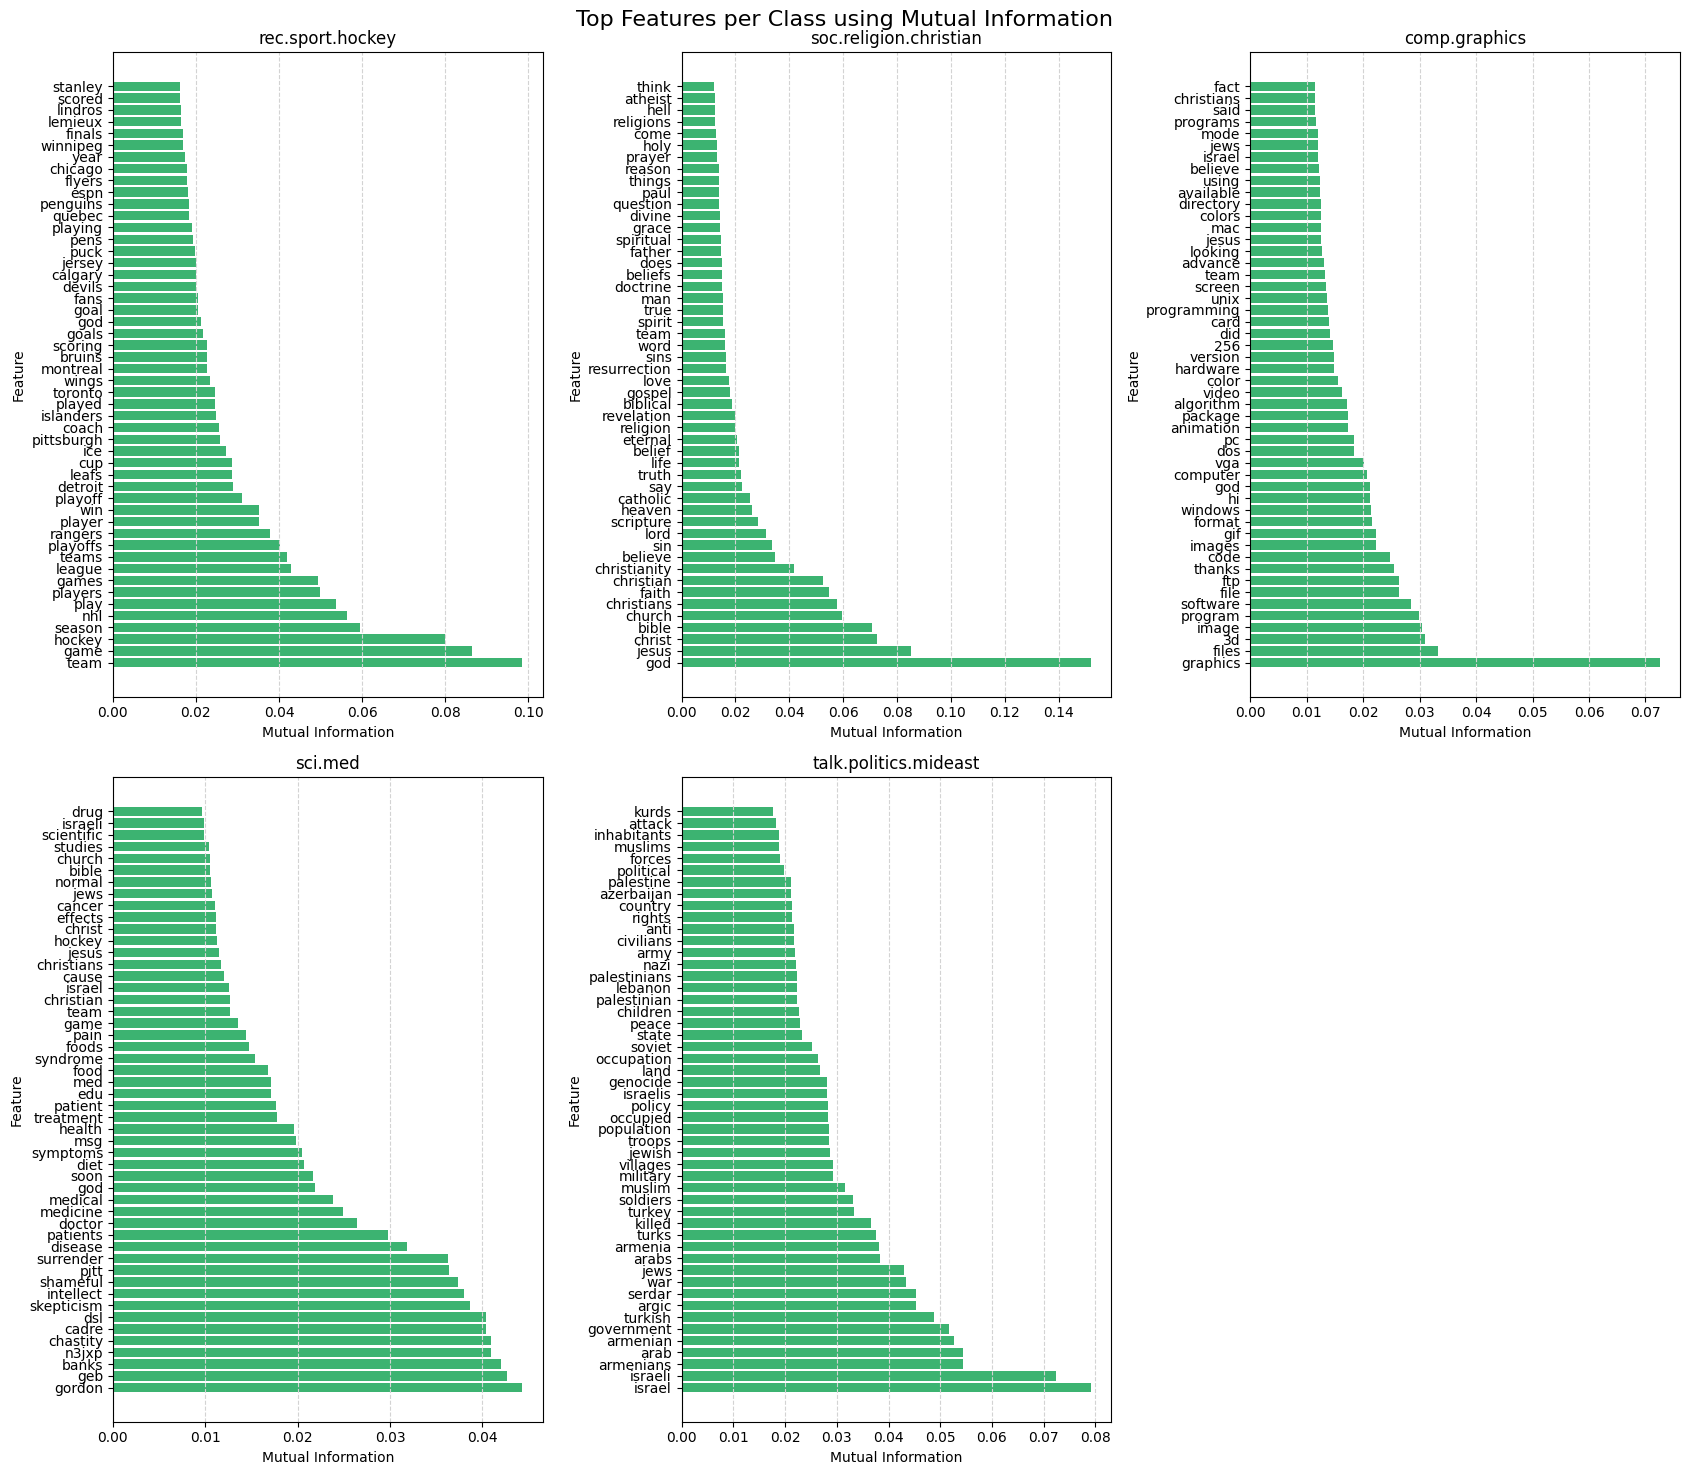

In [10]:
from sklearn.feature_selection import mutual_info_classif

top_features = []
for label in df['label'].unique():
    mi = mutual_info_classif(df[words_to_keep], df['label'] == label, n_neighbors=3, discrete_features=True, random_state=SEED)
    mi_df = pd.DataFrame({'word': words_to_keep, 'mi': mi})
    mi_df = mi_df.sort_values(by='mi', ascending=False).reset_index(drop=True)
    mi_df['label'] = label
    top_features.append(mi_df.head(50))

plt.figure(figsize=(17, 15))
for i, label in enumerate(df['label'].unique()):
    plt.subplot(2, 3, i+1)
    plt.barh(top_features[i]['word'], top_features[i]['mi'], label=newsgrp_ds.target_names[label], color='mediumseagreen')
    plt.xlabel('Mutual Information')
    plt.ylabel('Feature')
    plt.title(newsgrp_ds.target_names[label])
    plt.grid(axis='x', linestyle='--', color='lightgray')

plt.suptitle('Top Features per Class using Mutual Information', fontsize=16)
plt.tight_layout()
plt.show()

##### <b>Standardizing data</b>

In [11]:
from sklearn.preprocessing import StandardScaler

# concatenate top 50 features per class
top_features_df = pd.concat(top_features)
top_features_df = top_features_df.sort_values(by='mi', ascending=False).reset_index(drop=True)


# create training dataframes with union of 50 top features per class
features = top_features_df['word'].unique()
news_train_df = df.loc[:, features]
news_train_df['label'] = df['label']
news_train_df['label_name'] = df['label_name']
print("Training dataframe with top 50 features per class:")
X = news_train_df[news_train_df.columns[:-2]]
y_train = news_train_df['label']

y = np.zeros((len(y_train), len(np.unique(y_train))))
for i, label in enumerate(np.unique(y_train)):
    y[y_train == label, i] = 1

X = X.to_numpy()

#standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


#test set preprocessing
test_ds = sklearn.datasets.fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=('comp.graphics', 'sci.med', 'soc.religion.christian', 'talk.politics.mideast', 'rec.sport.hockey'))
test_df = pd.DataFrame({'text': test_ds.data, 'label': test_ds.target, 'label_name': [test_ds.target_names[i] for i in test_ds.target]})
test_df['text'] = test_df['text'].apply(lambda x: x.replace('\n', ' ').replace('\t', ' ').replace('\r', ' '))
vectorizer = CountVectorizer(vocabulary=features)
test_words = vectorizer.fit_transform(test_df['text'])
test_words = test_words.toarray()

#X_test = X_test[:, np.where(np.isin(words, features))[0]]

X_test_df = pd.DataFrame(test_words, columns=features)
X_test_df['label'] = test_df['label']
X_test_df['label_name'] = test_df['label_name']
X_test_df

X_test = X_test_df[X_test_df.columns[:-2]]
y_test = test_df['label']

temp_y = np.zeros((len(y_test), len(np.unique(y_test))))
for i, label in enumerate(np.unique(y_test)):
    temp_y[y_test == label, i] = 1

y_test = temp_y
X_test = X_test.to_numpy()
X_test = scaler.transform(X_test)
X_test, y_test

Training dataframe with top 50 features per class:


(array([[-0.18546056, -0.12035904, -0.15918196, ..., -0.10420154,
         -0.10223661, -0.09333091],
        [-0.18546056, -0.12035904, -0.15918196, ..., -0.10420154,
         -0.10223661, -0.09333091],
        [ 0.74851119, -0.12035904, -0.15918196, ..., -0.10420154,
         -0.10223661, -0.09333091],
        ...,
        [-0.18546056, -0.12035904, -0.15918196, ..., -0.10420154,
         -0.10223661, -0.09333091],
        [-0.18546056, -0.12035904, -0.15918196, ..., -0.10420154,
         -0.10223661, -0.09333091],
        [-0.18546056, -0.12035904, -0.15918196, ..., -0.10420154,
         -0.10223661, -0.09333091]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]))

In [12]:
# train and validation set

from sklearn.model_selection import train_test_split

X_imdb = imdb_df[imdb_top_features['feature']]
y_imdb = imdb_df['label']

y_imdb = np.array(list(map(lambda x: 0 if x == '-' else 1, y_imdb)))

X_train_imdb, X_validate_imdb, y_train_imdb, y_validate_imdb = train_test_split(X_imdb, y_imdb, test_size=0.20, random_state=SEED)

scaler = StandardScaler()
X_train_imdb = scaler.fit_transform(X_train_imdb)
X_validate_imdb = scaler.transform(X_validate_imdb)

### <font color='red'><b>Task 2: Logistic and Multiclass classifiers</b></font>

#### <b>2.1 Logistic Regression on IMDB data</b>

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

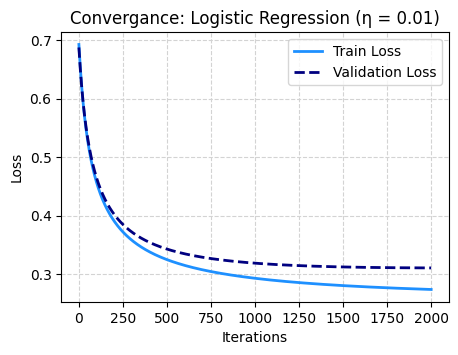

In [13]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iters=1000, verbose=False, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.verbose = verbose
        self.epsilon = epsilon
        self.weights = None
        self.bias = None

    def fit(self, X, y, X_val=None, y_val=None):
        # Initialize weights and bias
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Store losses at each iteration
        self.train_losses = []
        self.val_losses = []

        for i in tqdm(range(self.max_iters), desc='Iteration', unit='iteration'):
            # Compute model output
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Compute and store training loss
            train_loss = -np.mean(y * np.log(y_predicted + self.epsilon) + (1 - y) * np.log(1 - y_predicted + self.epsilon))
            self.train_losses.append(train_loss)

            # Compute and store validation loss if validation data is provided
            if X_val is not None and y_val is not None:
                y_val_predicted = self.predict_proba(X_val)
                val_loss = -np.mean(y_val*np.log(y_val_predicted + self.epsilon) + (1-y_val)*np.log(1-y_val_predicted + self.epsilon))
                self.val_losses.append(val_loss)

            # Print loss
            if self.verbose and i % 100 == 0:
                print(f'Train Loss at iteration {i}: {train_loss}')
                if X_val is not None and y_val is not None:
                    print(f'Validation Loss at iteration {i}: {val_loss}')
                    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return np.array([1 if i > 0.5 else 0 for i in self._sigmoid(linear_model)])

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def plot_loss(model):
    plt.figure(figsize=(5, 3.5))
    plt.plot(range(model.max_iters), model.train_losses, label='Train Loss', color='dodgerblue', linewidth=2)
    plt.plot(range(model.max_iters), model.val_losses, label='Validation Loss', color='navy', linewidth=2, linestyle='dashed')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Convergance: Logistic Regression (η = 0.01)')
    plt.legend()
    plt.grid(linestyle='--', color='lightgray')
    plt.show()

# Initialize the LogisticRegression class
model_lr = LogisticRegression(learning_rate=0.01, max_iters=2000, verbose=False)

# Fit the model to the data
model_lr.fit(X_train_imdb, y_train_imdb, X_validate_imdb, y_validate_imdb)

# Plot loss vs iterations for training and validation set
plot_loss(model_lr)

#### <b>2.2 Multiclass Regression on 20 news-group Data</b>

Checking gradient
2.278169296861749e-13


Iteration:   0%|          | 0/500 [00:00<?, ?iteration/s]

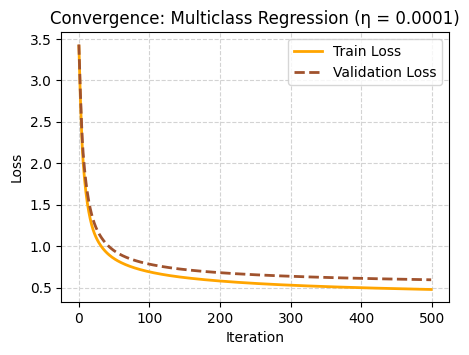

In [37]:
from scipy.special import softmax

class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses, verbose=False):
        self.W = np.random.rand(nFeatures, nClasses)
        self.verbose = verbose

    def predict(self, X):
        # y_pred = np.exp(np.matmul(X, self.W))
        y_pred = softmax(np.matmul(X, self.W), axis=1)
        return y_pred

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.0001, niter=100, tol=1e-4):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in tqdm(range(niter), desc='Iteration', unit='iteration'):
            ## stopping criteria
            old_W = self.W.copy()
            self.W = self.W - lr * self.grad(X, y)
            if np.linalg.norm(self.W - old_W) < tol:
                break
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid

                if self.verbose:
                    print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                if self.verbose:
                    print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=SEED)

D = X_train.shape[1]
C = y_train.shape[1]

model = Multinomial_logistic(D, C, verbose=False)

print("Checking gradient")
print(model.check_grad(X_train, y_train))

ce_train, ce_val = model.fit(X_train, y_train, X_valid, y_valid, niter=500)

plt.figure(figsize=(5, 3.5))
plt.clf()
plt.plot(ce_train/X_train.shape[0], label='Train Loss', color='orange', linewidth=2)
plt.plot(ce_val/X_valid.shape[0], label='Validation Loss', color='sienna', linewidth=2, linestyle='dashed')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Convergence: Multiclass Regression (η = 0.0001)')
plt.grid(linestyle='--', color='lightgray')
plt.show()

### <font color='red'><b>Task 3: Experiments</b></font>

### <b>3 (A) Logistic Regression evaluation</b>

In [15]:
# test set
test_imdb_neg_df = format_dataset(path='datasets/aclImdb/test/neg')
test_imdb_pos_df = format_dataset(path='datasets/aclImdb/test/pos')
test_imdb_df = pd.concat([test_imdb_pos_df, test_imdb_neg_df], axis=0)
test_imdb_df = test_imdb_df.reset_index(drop=True)

vectorizer = CountVectorizer(vocabulary=imdb_top_features['feature'])
X_test_imdb = vectorizer.fit_transform(test_imdb_df['reviews'])
X_test_imdb = pd.DataFrame(X_test_imdb.toarray(), columns=vectorizer.get_feature_names_out())
X_test_imdb = scaler.transform(X_test_imdb)

y_test_imdb = np.array(list(map(lambda x: 0 if x == '-' else 1, test_imdb_df['label'])))

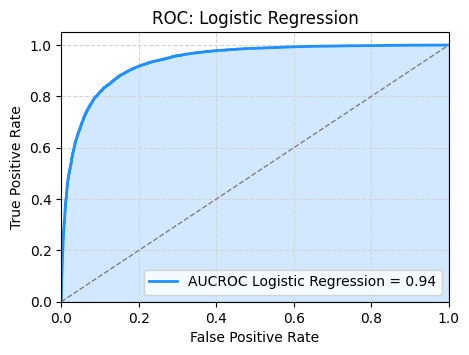

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model, X, y):
    y_scores = model_lr.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_scores)
    auc = roc_auc_score(y, y_scores)
    
    plt.figure(figsize=(5, 3.5))
    plt.plot(fpr, tpr, color='dodgerblue', lw=2, label=f'AUCROC Logistic Regression = {auc:.2f}')
    plt.axline((0, 0), (1, 1), linestyle="--", lw=1, color='gray')
    plt.fill_between(fpr, tpr, color='dodgerblue', alpha=0.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: Logistic Regression')
    plt.legend(loc='lower right')
    plt.grid(linestyle='--', color='lightgray')
    plt.show()

plot_roc_curve(model, X_test_imdb, y_test_imdb)

#### <b>Decision Trees on the IMDB data</b>

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt_model = DecisionTreeClassifier(random_state=SEED, criterion='entropy', max_depth=25)
dt_model.fit(X_train_imdb, y_train_imdb)
y_pred_dt = dt_model.predict(X_validate_imdb)

f1 = f1_score(y_validate_imdb, y_pred_dt)
print(f'DT Validation F1: {f1:.2f}')

DT Validation F1: 0.73


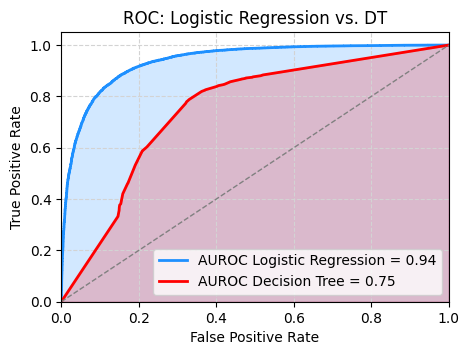

In [18]:
# Logistic Regression ROC
y_scores_lr = model_lr.predict_proba(X_test_imdb)
fpr_lr, tpr_lr, _ = roc_curve(y_test_imdb, y_scores_lr)
auc_lr = roc_auc_score(y_test_imdb, y_scores_lr)

# Decision Tree ROC
y_scores_dt = dt_model.predict_proba(X_test_imdb)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test_imdb, y_scores_dt)
auc_dt = roc_auc_score(y_test_imdb, y_scores_dt)

# Plot ROC curves for both models
plt.figure(figsize=(5, 3.5))
# Logistic Regression
plt.plot(fpr_lr, tpr_lr, color='dodgerblue', lw=2, label=f'AUROC Logistic Regression = {auc_lr:.2f}')
plt.fill_between(fpr_lr, tpr_lr, color='dodgerblue', alpha=0.2)

# Decision Tree
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label=f'AUROC Decision Tree = {auc_dt:.2f}')
plt.fill_between(fpr_dt, tpr_dt, color='red', alpha=0.2)

# Plot the diagonal line
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Logistic Regression vs. DT')
plt.legend(loc='lower right')
plt.grid(linestyle='--', color='lightgray')
plt.show()

#### <b>AUROC vs size for Logistic Regression & Decision Tree</b>

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

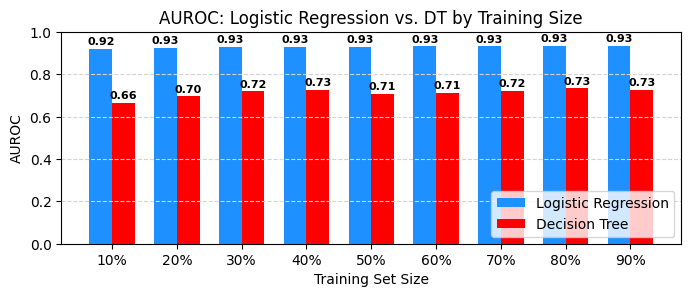

In [19]:
training_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initialize lists to store AUC values
auc_lr_values = []
auc_dt_values = []

# Loop through different training sizes
for size in training_sizes:
    # Split the data into training and test sets
    X_train, _, y_train, _ = train_test_split(X_imdb, y_imdb, test_size=1 - size, random_state=SEED)
    X_test, _, y_test, _ = train_test_split(X_test_imdb, y_test_imdb, test_size=1 - size, random_state=SEED)

    # Logistic Regression
    model_logistic = LogisticRegression(learning_rate=0.01, max_iters=2000)
    model_logistic.fit(X_train, y_train)
    y_scores_lr = model_logistic.predict_proba(X_test)
    auc_lr = roc_auc_score(y_test, y_scores_lr)
    auc_lr_values.append(auc_lr)

    # Decision Tree
    dt_model = DecisionTreeClassifier(random_state=SEED, criterion='entropy', max_depth=25)
    dt_model.fit(X_train, y_train)
    y_scores_dt = dt_model.predict_proba(X_test)[:, 1]
    auc_dt = roc_auc_score(y_test, y_scores_dt)
    auc_dt_values.append(auc_dt)

# Plotting
bar_width = 0.35
index = np.arange(len(training_sizes))

plt.figure(figsize=(8, 2.75))
plt.bar(index, auc_lr_values, bar_width, label='Logistic Regression', color='dodgerblue')
plt.bar(index + bar_width, auc_dt_values, bar_width, label='Decision Tree', color='red')

plt.xlabel('Training Set Size')
plt.ylabel('AUROC')
plt.title('AUROC: Logistic Regression vs. DT by Training Size')
plt.xticks(index + bar_width / 2, [f'{int(size * 100)}%' for size in training_sizes])
plt.ylim(top=1.0)
# Adding AUROC values on top of the bars
for i, value in enumerate(auc_lr_values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='black', weight='bold', fontsize=8)

for i, value in enumerate(auc_dt_values):
    plt.text(i + bar_width, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='black',  weight='bold', fontsize=8)

plt.legend(loc='lower right')
plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

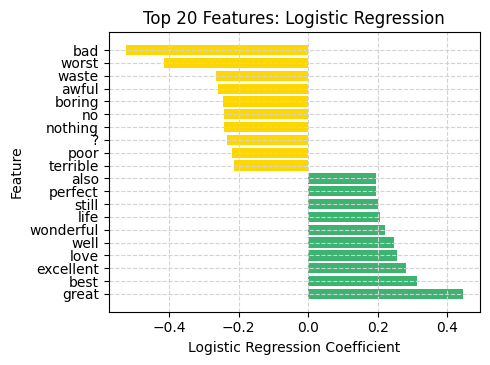

In [20]:
class LogisticRegressionWithCoef(LogisticRegression):
    def fit(self, X, y, X_val=None, y_val=None):
        super().fit(X, y, X_val, y_val)
        self.coefficients = self.weights

logistic_model = LogisticRegressionWithCoef(learning_rate=0.01, max_iters=2000, verbose=False)

# Fit the logistic regression model
logistic_model.fit(X_imdb, y_imdb)

# Retrieve the coefficients and feature names
coefficients = logistic_model.coefficients
feature_names = X_imdb.columns

# Create a DataFrame with coefficients and feature names
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df = coef_df.sort_values(by='coefficient', ascending=False).reset_index(drop=True)

# Select the top 20 features (10 most positive and 10 most negative)
top_features = pd.concat([coef_df.head(10), coef_df.tail(10)])

plt.figure(figsize=(5, 3.75))
colors = ['mediumseagreen' if c > 0 else 'gold' for c in top_features['coefficient']]
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel('Logistic Regression Coefficient')
plt.ylabel('Feature')
plt.title('Top 20 Features: Logistic Regression')
plt.grid(axis='both', linestyle='--', color='lightgray')
plt.tight_layout()
plt.show()

### <b>3 (B) Multiclass Regression evaluation</b>

In [21]:
df = pd.DataFrame(data.toarray(), columns=words)
df = df[words_to_keep]
df['label'] = newsgrp_df['label']
df['label_name'] = newsgrp_df['label_name']
df

top_features = []
for label in df['label'].unique():
    mi = mutual_info_classif(df[words_to_keep], df['label'] == label, n_neighbors=3, discrete_features=True, random_state=SEED)
    mi_df = pd.DataFrame({'word': words_to_keep, 'mi': mi})
    mi_df = mi_df.sort_values(by='mi', ascending=False).reset_index(drop=True)
    mi_df['label'] = label
    top_features.append(mi_df.head(50))

# concatenate top 50 features per class
top_features_df = pd.concat(top_features)
top_features_df = top_features_df.sort_values(by='mi', ascending=False).reset_index(drop=True)


# create training dataframes with union of 50 top features per class
features = top_features_df['word'].unique()
news_train_df = df.loc[:, features]
news_train_df['label'] = df['label']
news_train_df['label_name'] = df['label_name']
print("Training dataframe with top 50 features per class:")
X = news_train_df[news_train_df.columns[:-2]]
y_train = news_train_df['label']

y = np.zeros((len(y_train), len(np.unique(y_train))))
for i, label in enumerate(np.unique(y_train)):
    y[y_train == label, i] = 1

X = X.to_numpy()

#standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=SEED)

X_test_df = pd.DataFrame(test_words, columns=features)
X_test_df['label'] = test_df['label']
X_test_df['label_name'] = test_df['label_name']
X_test_df

X_test = X_test_df[X_test_df.columns[:-2]]
y_test = test_df['label']

temp_y = np.zeros((len(y_test), len(np.unique(y_test))))
for i, label in enumerate(np.unique(y_test)):
    temp_y[y_test == label, i] = 1

y_test = temp_y
X_test = X_test.to_numpy()
X_test = scaler.transform(X_test)
X_test, y_test


def evaluate(y_true, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y_true.argmax(axis=1))
    accuracy = accuracy / y_true.shape[0]
    return accuracy

train_accuracy = evaluate(y_train, model.predict(X_train))
val_accuracy = evaluate(y_valid, model.predict(X_valid))
print(f'Train Accuracy: {train_accuracy:.3f}, Validation Accuracy: {val_accuracy:.3f}')

test_accuracy = evaluate(y_test, model.predict(X_test))
print(f'Test Accuracy: {test_accuracy:.3f}')

Training dataframe with top 50 features per class:
Train Accuracy: 0.831, Validation Accuracy: 0.778
Test Accuracy: 0.750


#### Mutliclass top features for each class heatmap

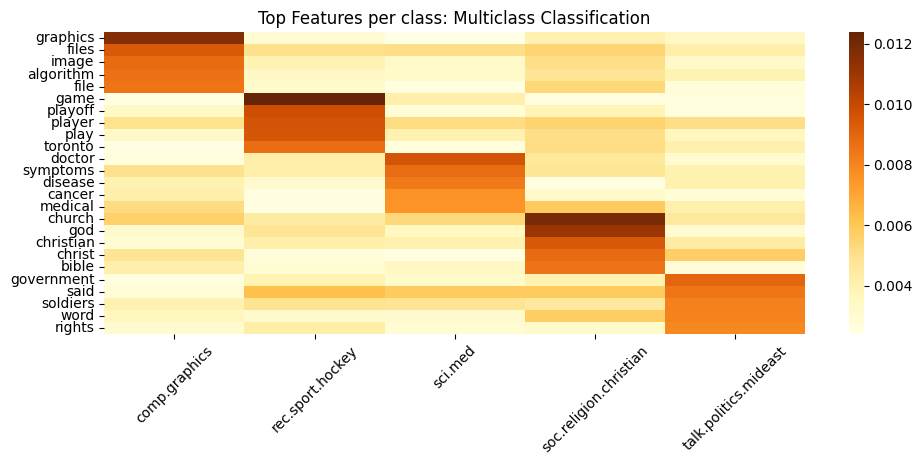

In [22]:
from seaborn import heatmap

plt.figure(figsize=(10, 4.75))
W_hat = model.W[:-1, :]

W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)[None, :]

# top 5 words for each class
top_words = []
top_words_w = []
for i in range(W_hat_transformed.shape[1]):
    top_idx = W_hat_transformed[:, i].argsort()[-5:][::-1]
    for idx in top_idx:
        top_words.append(features[idx])
        top_words_w.append(W_hat_transformed[idx, :])

W_hat_transformed_df = pd.DataFrame(top_words_w, index=top_words, columns=newsgrp_ds.target_names)

hmp = heatmap(top_words_w, yticklabels=top_words, xticklabels=newsgrp_ds.target_names, cmap='YlOrBr')

plt.xticks(rotation=45) 
plt.title('Top Features per class: Multiclass Classification')
plt.tight_layout()
plt.show()

#### <b>Decision Trees on 5-news group</b>

In [23]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)
val_accuracy = clf.score(X_valid, y_valid)
print(f'Train Accuracy: {train_accuracy:.3f}, Validation Accuracy: {val_accuracy:.3f}')

test_accuracy = clf.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.3f}')

Train Accuracy: 0.863, Validation Accuracy: 0.685
Test Accuracy: 0.650


#### <b>Accuracy vs size for Mutliclass logistic regression & Decision Tree </b>

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

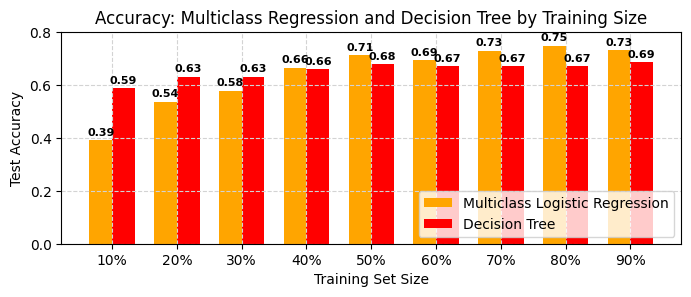

In [24]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
size_accuracies_mc = []
size_accuracies_dt = []

for size in sizes:
    _, X_train, _, y_train = train_test_split(X, y, test_size=size, random_state=SEED)

    D = X_train.shape[1]
    C = y_train.shape[1]

    model = Multinomial_logistic(D, C)
    model.fit(X_train, y_train, niter=100)
    mc_test_accuracy = evaluate(y_test, model.predict(X_test))
    size_accuracies_mc.append(mc_test_accuracy)

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    dt_test_accuracy = clf.score(X_test, y_test)
    size_accuracies_dt.append(dt_test_accuracy)

X_axis = np.arange(len(sizes))
plt.figure(figsize=(8, 2.75))
bar_width = 0.35

plt.bar(X_axis - bar_width / 2, size_accuracies_mc, label='Multiclass Logistic Regression', color='orange', width=bar_width)
plt.bar(X_axis + bar_width / 2, size_accuracies_dt, label='Decision Tree', color='red', width=bar_width)

# Adding accuracy values on top of the bars
for i, (mc_acc, dt_acc) in enumerate(zip(size_accuracies_mc, size_accuracies_dt)):
    plt.text(X_axis[i] - bar_width / 2, mc_acc + 0.01, f'{mc_acc:.2f}', ha='center', va='bottom', color='black',  weight='bold', fontsize=8)
    plt.text(X_axis[i] + bar_width / 2, dt_acc + 0.01, f'{dt_acc:.2f}', ha='center', va='bottom', color='black',  weight='bold', fontsize=8)

plt.ylim(top=0.8)

plt.legend(loc='lower right')
plt.xticks(X_axis, [f'{int(size * 100)}%' for size in sizes])
plt.xlabel('Training Set Size')
plt.ylabel('Test Accuracy')
plt.title('Accuracy: Multiclass Regression and Decision Tree by Training Size')
plt.grid(linestyle='--', color='lightgray')
plt.show()


#### <b>Accuracy of the two models i.e. Logistic Reas a function of the size of dataset (by controlling the training size)</b>

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

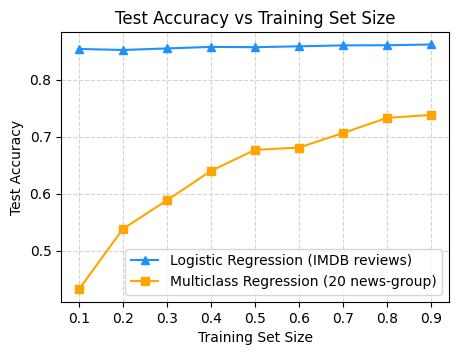

In [40]:
from sklearn.model_selection import train_test_split

# Sizes for training set
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
size_accuracies_logistic = []  # To store logistic regression accuracies
size_accuracies_multiclass = []  # To store multiclass model accuracies

# Logistic Regression
for size in sizes:
    X_train_logistic, _, y_train_logistic, _ = train_test_split(X_imdb, y_imdb, test_size=1-size, random_state=SEED)
    X_test_logistic, _, y_test_logistic, _ = train_test_split(X_test_imdb, y_test_imdb, test_size=1-size, random_state=SEED)

    model_logistic = LogisticRegression(learning_rate=0.01, max_iters=2000)
    model_logistic.fit(X_train_logistic, y_train_logistic)

    test_accuracy_logistic = np.mean(model_logistic.predict(X_test_logistic) == y_test_logistic)
    size_accuracies_logistic.append(test_accuracy_logistic)

# Multiclass Model
for size in sizes:
    _, X_train, _, y_train = train_test_split(X, y, test_size=size, random_state=SEED)

    D = X_train.shape[1]
    C = y_train.shape[1]

    model = Multinomial_logistic(D, C)

    model.fit(X_train, y_train, niter=100)

    test_accuracy = evaluate(y_test, model.predict(X_test))
    size_accuracies_multiclass.append(test_accuracy)

plt.figure(figsize=(5, 3.5))
plt.plot(sizes, size_accuracies_logistic, marker='^', color='dodgerblue', label='Logistic Regression (IMDB reviews)')
plt.plot(sizes, size_accuracies_multiclass, marker='s', color='orange', label='Multiclass Regression (20 news-group)')
plt.xlabel('Training Set Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Training Set Size')
plt.legend()
plt.grid(linestyle='--', color='lightgray')
plt.show()

#### <b>Extra Experiments and evaluations</b>
<b>1. Comparing F1-score of all binary classifiers i.e. KNN, Decision Tree and Logistic Regression studied in class till date</b>

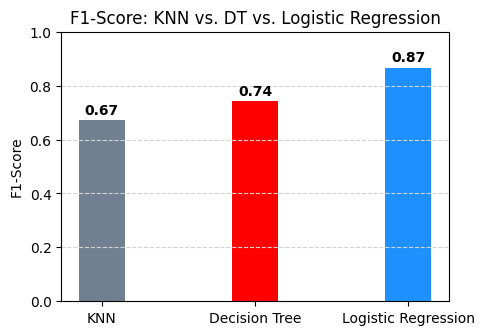

In [27]:
from sklearn.neighbors import KNeighborsClassifier

dt_model = DecisionTreeClassifier(random_state=SEED, criterion='entropy', max_depth=25)
dt_model.fit(X_train_imdb, y_train_imdb)
y_pred_dt = dt_model.predict(X_test_imdb)

knn_model = KNeighborsClassifier(n_neighbors=7) # neighbors tuned on validation set
knn_model.fit(X_train_imdb, y_train_imdb)
y_pred_knn = knn_model.predict(X_test_imdb)

y_scores_lr = model_lr.predict(X_test_imdb)

f1_dt = f1_score(y_test_imdb, y_pred_dt)
f1_knn = f1_score(y_test_imdb, y_pred_knn)
f1_lr = f1_score(y_test_imdb, y_scores_lr)

f1_scores = [f1_knn, f1_dt, f1_lr]
models = ['KNN', 'Decision Tree', 'Logistic Regression']
colors = ['slategray', 'red', 'dodgerblue']

plt.figure(figsize=(5, 3.5))
bars = plt.bar(models, f1_scores, color=colors, width=0.3)

# Add values on top of bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', va='bottom', weight='bold')

plt.ylabel('F1-Score')
plt.title('F1-Score: KNN vs. DT vs. Logistic Regression')
plt.ylim(0, 1) 
plt.grid(color='lightgray', linestyle='--', axis='y')
plt.show()

<b>2. Accuracy of a Multinomial Logistic Regression model by adjusting the number of training iterations</b>

Iteration:   0%|          | 0/50 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/100 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/200 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/500 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/1000 [00:00<?, ?iteration/s]

Iteration:   0%|          | 0/2000 [00:00<?, ?iteration/s]

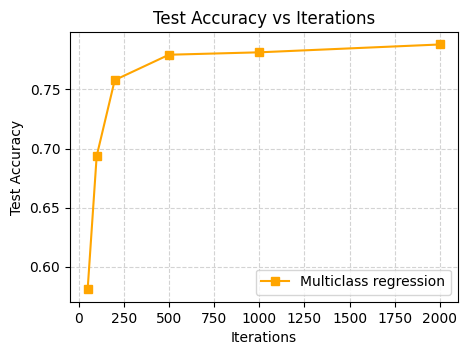

In [28]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=True)

D = X_train_news.shape[1]
C = y_train_news.shape[1]

model = Multinomial_logistic(D, C, verbose=False)

iterations = [50, 100, 200, 500, 1000, 2000]
acc = []
for iteration in iterations:
    model.fit(X_train_news, y_train_news, X_valid_news, y_valid_news, niter=iteration)
    test_accuracy = evaluate(y_test, model.predict(X_test))
    acc.append(test_accuracy)

plt.figure(figsize=(5, 3.5))
plt.plot(iterations, acc, marker='s', color='orange', label='Multiclass regression')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Iterations')
plt.grid(linestyle='--', color='lightgray')
plt.legend()
plt.show()